In [10]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [11]:
data = pd.read_csv('restaurant.csv')


# Data Cleansing


In [12]:
#drop below columns, as these info is free text type of data, which is unlikely to carry impactful info
new_data = data.drop(['_id', 'address', 'label', 'phone', 'restauranLink', 'restaurantName' ], axis = 1)

#convert ranking to numeric value for later PCA analysis
new_data['ranking'] = new_data['ranking'].str.split(' ', n=1, expand=True)[0].str.replace('#', '').str.replace(',' ,'')


#------------------------ Special Justification ---------------------------------------------------
#These 3 columns are a bit special, they are text based, but they seem contain categorical info. 
# I suspect that there could be cases that restaurants has more specific cuisine, e.g: American, or special service, 
# e.g: bar, could attract more good ratings, but specialized restaurant could be in dis-advantage as they have less
#services, due to this reason, I decided to convert the 3 columns into categorical columns, which will significantly 
#increase the total number of features.

new_data = new_data.join(new_data['cuisine'].str.replace(' ', '').str.get_dummies(sep=','))
new_data = new_data.join(new_data['openMeal'].str.replace(' ', '').str.get_dummies(sep=','))
new_data = new_data.join(new_data['region'].str.replace(' ', '').str.get_dummies(sep=',').add_prefix('region_'))

#drop text based data as it has been converted to numeric representation
new_data.drop(labels=['cuisine', 'openMeal', 'region'], axis=1,inplace = True)

#conver the $ to numeric value
def convert(col):
    col = str(col)
    if col == '$$$$':
        return  4
    elif col == '$$ - $$$':
        return 2.5
    elif col == '$$$':
        return 3
    elif col == '$$':
        return 2
    elif col == '$':
        return 1
    else:
        return 2.5

new_data['ratingAndPopularity'] = new_data['ratingAndPopularity'].apply(convert)

#------------------------ Special Justification ---------------------------------------------------
# Drop these columns: numbeOfReviews,numberAverage,numberExcellent,numberPoor,numberTerrible,numberVeryGood
# This is due to there are percentage based columns which deliver the same message:
# ratingAverage,ratingExcellent,ratingPoor,ratingTerrible,ratingVeryGood which is more meaningful than counts,
# As a new restaurant definitely has less number of counts than existing, but it could be a good restaurant

new_data.drop(labels=['numbeOfReviews', 'numberAverage', 'numberExcellent', 'numberPoor', 'numberTerrible', 'numberVeryGood'], axis=1,inplace = True)

#convert percentage string to float
new_data['ratingAverage'] = new_data['ratingAverage'].str.rstrip('%').astype('float') / 100.0
new_data['ratingExcellent'] = new_data['ratingExcellent'].str.rstrip('%').astype('float') / 100.0
new_data['ratingPoor'] = new_data['ratingPoor'].str.rstrip('%').astype('float') / 100.0
new_data['ratingTerrible'] = new_data['ratingTerrible'].str.rstrip('%').astype('float') / 100.0
new_data['ratingVeryGood'] = new_data['ratingVeryGood'].str.rstrip('%').astype('float') / 100.0


# Deal with missing Data and normalization

In [16]:
null_columns=new_data.columns[new_data.isnull().any()]
print(new_data[null_columns].isnull().sum())

from sklearn.preprocessing import Imputer
values = new_data.values

#------------------------ Justification --------------------------------------------
#Use median instead of mean, as mean may not represent most of the data and is greatly impacted by the outliners.

imputer = Imputer(missing_values='NaN', strategy='median', axis=0)
new_value = imputer.fit_transform(values)
new_data = pd.DataFrame(new_value)
sumry = new_data.describe().transpose()
print("Summary Statistics:\n",sumry,'\n')

data_std = StandardScaler().fit_transform(new_data)


Series([], dtype: float64)


c:\users\guofe\workspace\nus_is_pr\venv\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


Summary Statistics:
       count        mean         std    min     25%     50%     75%      max
0    1230.0    3.944715    0.429051   2.00    3.50    4.00    4.00     5.00
1    1230.0    4.174797    0.329483   3.00    4.00    4.00    4.50     5.00
2    1230.0    4.016667    0.397212   2.50    4.00    4.00    4.50     5.00
3    1230.0    3.843496    0.389679   2.50    3.50    4.00    4.00     5.00
4    1230.0  649.287805  360.074224  31.00  338.25  648.00  955.00  1449.00
5    1230.0    2.536585    0.735231   1.00    2.50    2.50    2.50     4.00
6    1230.0    0.130211    0.064051   0.00    0.08    0.13    0.17     0.42
7    1230.0    0.413276    0.153388   0.06    0.29    0.39    0.51     0.98
8    1230.0    0.034740    0.028423   0.00    0.01    0.03    0.05     0.19
9    1230.0    0.023065    0.022340   0.00    0.00    0.02    0.03     0.18
10   1230.0    4.114228    0.293267   3.50    4.00    4.00    4.50     5.00
11   1230.0    0.398707    0.109597   0.02    0.33    0.41    0.48 

# Run PCA


In [17]:
features = list(new_data)
colnames = np.transpose(features)

n_components = len(features)
pca = PCA(n_components).fit(data_std)

# generate PC labels:
PCs=[]
for l in range(1,n_components+1):
    PCs.append("PC"+str(l))
    
# Get Eigenvectors & Eigenvalues
eigvec = pca.components_.transpose()
eigval = pca.explained_variance_

# Calculate Loadings = Eigenvector * SQRT(Eigenvalue)
# print('Loading Matrix:')
loadings= np.sqrt(eigval)*eigvec
# print(pd.DataFrame(loadings,columns=PCs,index=colnames),'\n')

print('\nEigenvectors (Linear Coefficients):')
print(pd.DataFrame(eigvec,columns=PCs,index=colnames),'\n')

var_expln= pca.explained_variance_ratio_ * 100
eigval = -np.sort(-eigval) #descending
npc = 60 # display-1
print("Eigenvalues   :",eigval[0:npc])
print("%Explained_Var:",var_expln[0:npc])
print("%Cumulative   :",np.cumsum(var_expln[0:npc]))
print('\n')



Eigenvectors (Linear Coefficients):
          PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0    0.177759 -0.128383 -0.009319 -0.034620  0.079483  0.024542 -0.048015   
1    0.157827 -0.108934  0.232019 -0.139751 -0.041754  0.051120 -0.011585   
2    0.220601 -0.150781  0.099613 -0.128701  0.018418  0.016860 -0.026131   
3    0.098872 -0.066203  0.227663 -0.114650 -0.017052  0.066029 -0.074617   
4   -0.125886  0.078153 -0.115328 -0.172256 -0.129584  0.095548 -0.053709   
5    0.127392 -0.103899 -0.041601 -0.055346  0.004875 -0.087070  0.099194   
6   -0.190909  0.130147 -0.180619  0.099372 -0.023226 -0.040738  0.012292   
7    0.249016 -0.165015  0.173504 -0.120708  0.043928  0.018585 -0.026593   
8   -0.069776  0.052903 -0.192613  0.145824 -0.028411 -0.027044  0.083680   
9   -0.068051  0.043796 -0.158202  0.156530 -0.017779 -0.022586  0.081895   
10   0.207870 -0.134789  0.185287 -0.171426  0.030420  0.046403 -0.059355   
11  -0.204975  0.132240 -0.055074  0.04

# Loading Plot


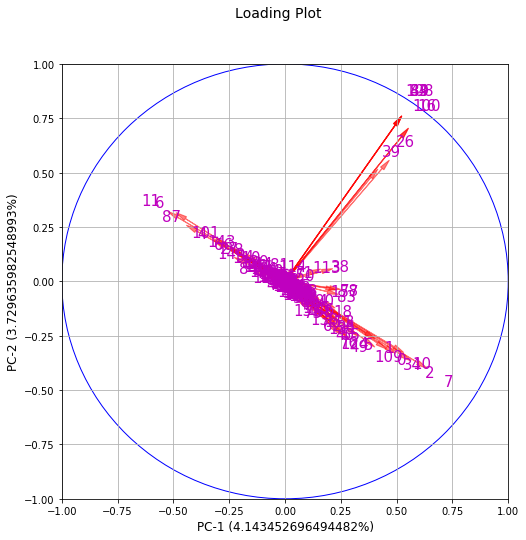

In [18]:
# (8) Loadings Plot
coeff = loadings[:,0:2]
fig = plt.figure(figsize=(8,8))
plt.xlim(-1,1)
plt.ylim(-1,1)
fig.suptitle('Loading Plot',fontsize=14)
plt.xlabel('PC-1 ('+str(var_expln[0])+'%)',fontsize=12)
plt.ylabel('PC-2 ('+str(var_expln[1])+'%)',fontsize=12)

for i in range(len(coeff[:,0])):
    plt.arrow(0,0,coeff[i,0],coeff[i,1],color='r',
              alpha=0.5,head_width=0.02, head_length=0.05,length_includes_head=True)
    plt.text(coeff[i,0]*1.15,coeff[i,1]*1.15,features[i],fontsize=15,
             color='m',ha='center',va='center')

circle = plt.Circle((0, 0), 0.9999999,  color='b', fill=False)
ax = fig.gca() 
ax.add_artist(circle)
plt.grid()
plt.show()


# Scree plot


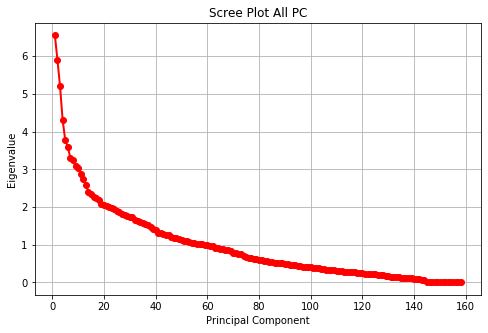

In [19]:
num_vars= len(features)
fig = plt.figure(figsize=(8,5))
sing_vals = np.arange(num_vars) + 1

plt.plot(sing_vals, eigval, 'ro-', linewidth=2)
plt.title('Scree Plot All PC')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()



# Analysis

I noticed the Eigenvalues dropped to below 1 at 60th principle components, and at 59th PC, its cumulative value is 77%.

The scree plot show that Eigenvlaue drops sharply till the 20th PC (the first bend), from 20-60, it dropped slower, 
but still faster than 60th PC onwards (The second bend), considering the earlier analysis of Eigenvalue and accumulated 
value, we should choose the first 59 components in future analysis.


